# Data Preprocessing

In [1]:
# This notebook was created with Google Colab.

# spacy (the NLP library we used for NER) is already installed in this environment.

# Before running this notebook, make sure your data is in a folder at the path "My Drive/Colab Notebooks/data".

##Installations and Imports

In [2]:
# Install neuralcoref if needed
!pip install git+https://github.com/huggingface/neuralcoref.git

  Cloning https://github.com/huggingface/neuralcoref.git to /tmp/pip-req-build-ig176acm
  Running command git clone -q https://github.com/huggingface/neuralcoref.git /tmp/pip-req-build-ig176acm


In [3]:
import spacy
import neuralcoref

import os

import numpy as np
import pandas as pd
import json

import matplotlib.pyplot as plt

from sklearn.decomposition import TruncatedSVD

## Read files

In [4]:
# Use Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Navigate to "Colab Notebooks folder"
%cd /content/drive/My Drive/Colab Notebooks

/content/drive/My Drive/Colab Notebooks


In [6]:
# Set up accumulation variables
string_files = ''
list_files = []
list_filenames = []

In [7]:
# Read files
for file in os.listdir('data'):
  with open('data//' + file) as f:
    line = f.readline()
    string_files += line
    list_files.append(line)
    list_filenames.append(file)

## Recognize named entities

In [8]:
# Load NLP functionality with English language
nlp = spacy.load('en')

In [9]:
# Load coreference functionality (tested, not used)
neuralcoref.add_to_pipe(nlp)

In [10]:
# Create a spacy Document object (contains named entities)
docs = nlp(string_files)

In [11]:
# Record coreferences (tested, not used)
coref_clusters = docs._.coref_clusters

In [12]:
# Set up named entities
names = [e for e in docs.ents if e.label_ == 'PERSON']
orgs = [e for e in docs.ents if e.label_ == 'ORG']
places = [e for e in docs.ents if e.label_ == 'GPE']
date = ['1 Aaril. 2003', '30 March, 2003', '22 December, 2001', '9 April, 2003', 'March of 2003', 'April 2003', '12 April. 2003', '8 April, 2002', '14 April, 2003', '1994', 'January of 2003', '20 April. 2003', '19 April', '20 April, 2003', '22 April, 2003', 'the late 1980s', '22 April, 2003', 'April 20,2003', 'April 21, 2003', '24 April, 2003', '23 April, 2003', '25 April, 2003', '27 Auril. 2003', '1996', '27 April, 2003', '1990 - 1992', '1987 - 1993', 'March, 1993', '1 April, 2003', '5 April, 2003', '12 Feb. 19971', '8 April, 2003', '7 April, 2003', '1 April, 2003', '6 April, 2003', '7 April', '6 April', '13 April, 2003', '10 April, 2003', '13 April, 2003', '10 April, 2003', '16 April, 2003', '15, April 2003', '13 April, 2003', '15 April. 2003', '11 April, 2003', '15 April. 2003', '14 April, 2003', '16 April, 2003', '15 Apr 1, 2003', 'April 18. 2003', '12 December, 2001', '1999', '18 April, 2003', '19 April, 2003', '20 April, 2003', '20 April, 2003', '20 April. 2003', '22 April, 2003', '16 April, 2003', '22 April, 2003', '25 April. 2003', '20 April, 2003', '22 April, 2003', '25 Auril. 2003', '29 April, 2003', '23 April, 2003', '26 April, 2003', '10 April, 2003', '26 April, 2003', '25 April, 2003', '29 April, 1930hrs', '27 April, 2003', '27 April. 2003', '2 April', '27 April, 2003', '27 April. 2003', 'April 26,2003', '10 April. 2003', '30 March. 2003', '6 April, 2003', '20 April. 2003', 'April 25,2003', '21 April, 2003', '24 April, 2003', '22 April, 2003', 'April 30', '27 April. 2003', '26 April, 2003']
phone = ['703-659-2317', '703-734-0104', '804- 774-8920', '804-759-6302', '706-437-6673', '713-556-9213', '718-352-8479', '732-455-6392', '01 1207670734', '804-774-8920', '703-659-2317'] # 732-455-6329 not found in document
bank = ['1070173749003']

In [13]:
# Set up list of named entity types
ner_types = ['PERSON', 'ORG', 'DATE', 'GPE', 'PHONE', 'BANK']

In [14]:
# Gets unique named entities (still vulnerable to typos and abbreviations and phrases like "the last 3 months")
docents_short = names + orgs + places
docents_short = {k:v for (k,v) in zip([e.text for e in docents_short], [e.label_ for e in docents_short])}
docents_short.update({k:'DATE' for k in date})
docents_short.update({k:'PHONE' for k in phone})
docents_short.update({k:'BANK' for k in bank})

## Start building JSON object

In [15]:
# Builds JSON containing:
#   terms
#   NER types
#   terms' connections with documents
#   terms' connections with other terms (i.e., what other terms are in the documents the original term is in)

# Initial JSON format: {term: [NER type, [doc links], {term links}]}

In [16]:
# Set up containers
build_doc_links = []
build_term_links = []

dict_files = {k:v for (k,v) in zip(list_filenames, list_files)}

In [17]:
# Compute doc links
doc_links = []
for key in docents_short:
  build_doc_links = set()

  for filename in dict_files:
    # Finds term in document
    if (dict_files[filename].find(key) == -1):    # if term not found in document
      doc_presence = 0
    else:
      doc_presence = filename                     # if term found in document

    # Accumulates document link information
    if (doc_presence != 0):
      build_doc_links.add(doc_presence)

  # Record doc links
  doc_links.append(list(build_doc_links))

In [18]:
# Compute term links
term_links = []
num_doc_links = 0

for term, filenames in zip(docents_short, doc_links):
  build_term_links = {}

  # Looks at each linked file
  for filename in filenames:

    # Looks for term in document
    for link_candidate in docents_short:
      if (dict_files[filename].find(link_candidate) == -1):
        continue

      # Accumulates term link information if found
      else:
        if (link_candidate != term):

          # Compute number of links
          if (link_candidate not in build_term_links):
            num_doc_links = 1
          else:
            print(link_candidate)
            num_doc_links += 1

          # Add linked term to intermediate dict
          build_term_links.update({link_candidate: num_doc_links})

  # Link related terms to main term
  term_links.append(build_term_links)

Ramazi
U
Ramazi
FBI
U
Springfield
VA
US
Ramazi
FBI
First Union Bank
U
Springfield
VA
1070173749003
Ramazi
FBI
U
Springfield
VA
Egypt
Cairo
1070173749003
Abdul Ramazi
U
Abdul Ramazi
FBI
U
Springfield
VA
US
Abdul Ramazi
FBI
First Union Bank
U
Springfield
VA
1070173749003
Abdul Ramazi
FBI
U
Springfield
VA
Egypt
Cairo
1070173749003
Texas
Houston
FBI
NYSE
FBI
NYC
VA
Charlottesville
FBI
U
VA
Virginia
Charlottesville
Yasein Mosed
FBI
NYC
VA
Charlottesville
Mukhtar Galab
FBI
VA
Charlottesville
NYC
North Bergen
Hani al
al Hallak
FBI
VA
Goba
Capitol Ave
Richmond
804-759-6302
Goba
FBI
VA
U
Apartment
Denver
Colorado
2 April
Hani al
Hani al Hallak
Hani al
al Hallak
FBI
VA
North Bergen
Hani al Hallak
North Bergen
al Hallak
FBI
VA
Hani al Hallak
North Bergen
Hani al
FBI
VA
VA
Richmond
804-759-6302
Faysal Goba
Capitol Ave
Richmond
804-759-6302
Faysal Goba
FBI
VA
CIA
al Ahdal
bin Attash
CIA
Saeed Khallad
bin Attash
CIA
Saeed Khallad
al Ahdal
CIA
The Netherlands
Richmond
Keswick
Virginia
U
VA
1 April, 2

In [19]:
# Record JSON objects
build_json = {}
for key, docs, terms in zip(docents_short, doc_links, term_links):
  build_json.update({key: [docents_short[key], docs, terms]})

In [20]:
# View JSON object so far
build_json

{'01 1207670734': ['PHONE',
  ['se4.txt', 'se3.txt'],
  {'1 April, 2003': 1,
   '2 April': 1,
   '2003:----- Frequent': 1,
   '21 April, 2003': 1,
   '22 April, 2003': 1,
   '24 April, 2003': 1,
   '703-659-2317': 2,
   '718-352-8479': 4,
   '804-759-6302': 3,
   '804-774-8920': 5,
   'Amsterdam': 1,
   'April 30': 1,
   'Bagwant Dhaliwal': 1,
   'Charlottesville': 1,
   'Clark Webster': 1,
   'Hans Pakes': 1,
   'Mukhtar Galab': 1,
   'NYC': 1,
   'OOAM': 1,
   'Richmond': 1,
   'The Netherlands': 1,
   'VA': 1}],
 '1 Aaril. 2003': ['DATE',
  ['cia1.txt'],
  {'22 December, 2001': 1,
   '30 March, 2003': 1,
   'American Airlines': 1,
   'BSB': 1,
   'CIA': 1,
   'London': 1,
   'Miami': 1,
   'Omar Bakri Qatada': 1,
   'Paris': 1,
   'Qatada': 1,
   'Richard Reid': 1,
   "St. Mary's": 1,
   'addington': 1}],
 '1 April, 2003': ['DATE',
  ['fbi1.txt', 'se3.txt', 'fbi3.txt', 'fbi7.txt'],
  {'01 1207670734': 1,
   '1070173749003': 1,
   '11 April, 2003': 1,
   '15 April. 2003': 1,
   '2003

##Reduce dimensionality

In [21]:
# Prepare color (type) list for elementary visualization
ner_list = []
for term in build_json:
  ner_list.append(ner_types.index(build_json[term][0]))

### Reduce dimensionality with LSA

In [22]:
# Build dict of lists to build dataframe matrix
build_df = {}

# Start with file names to get number of rows needed
# We will later transform this list into df labels
list_terms = [term for term in docents_short]

# Get terms' frequencies in the documents
for term1 in list_terms:
  build_col = []

  for term2 in list_terms:
    # Count the number of documents the terms in this pair are both linked to
    if term2 in build_json[term1][2]:
      build_col.append(build_json[term1][2][term2])
    elif term1 == term2:
      build_col.append(len(build_json[term1][1]))
    else:
      build_col.append(0)
  
  build_df[term1] = build_col

# Build dataframe
df = pd.DataFrame(build_df, index = list_terms)

# View beginning of dataframe
df.head()

,Abdul Ramazi,Ramazi,Floyd Ave,Karim Bensaid,Hubbard St.,Bensaid,Sheldon St.,Wallace Wilson,Wilson,wallace Wilson,...,703-734-0104,804- 774-8920,804-759-6302,706-437-6673,713-556-9213,718-352-8479,732-455-6392,01 1207670734,804-774-8920,1070173749003
Abdul Ramazi,5,3,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,2
Ramazi,3,5,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,3
Floyd Ave,1,1,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
Karim Bensaid,0,0,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Hubbard St.,0,0,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
# Set up data to be used for dimensionality reduction
X = df.copy()

In [24]:
# Set up LSA (alternative to PCA for sparse data)
# Transforms matrix to 2 dimensions for visual representation
lsa = TruncatedSVD(n_components = 2)
lsa_result = lsa.fit_transform(X)
lsa_list = lsa_result.tolist()

In [25]:
# Slices coordinate list into values from each column and combines them with numerical conversion (index) of NER types from ner_list created earlier
zipped = list(zip(lsa_result[:, :1].ravel().tolist(), lsa_result[:, 1:].ravel().tolist(), ner_list))
result = pd.DataFrame(zipped)

# Show data to be visualized
result

,0,1,2
0,8.115358,-1.276687,0
1,9.924709,-1.121742,0
2,2.411880,-0.358035,0
3,1.997802,0.271297,0
4,1.997802,0.271297,0
...,...,...,...
274,2.555632,-0.288045,4
275,0.428204,0.262013,4
276,2.339142,-0.611390,4
277,2.810148,-0.565698,4


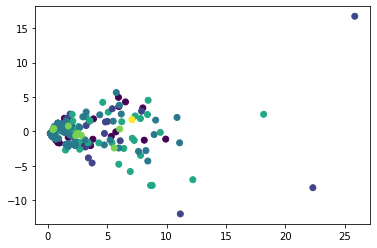

In [26]:
# Show elementary visualization
plt.scatter(result.iloc[:, 0], result.iloc[:, 1], c = result.iloc[:, 2])

## Save JSON to file

In [27]:
# Final JSON format: {term: [NER type, [doc links], {term links}, [2D coordinates]]}

In [ ]:
# Add LSA results to JSON as coordinates
for term, coords in zip(build_json, lsa_list):
  build_json[term].append(coords)

build_json

In [29]:
# Save JSON to file
with open('terms.json', 'w') as outf:
  json.dump(build_json, outf)

## Link coreferences (work in progress)

In [30]:
from collections import defaultdict
from copy import deepcopy

In [31]:
# Gets corefs
docents_linked = defaultdict(set)
docents_add = defaultdict(set)

# Adds co-terms to new entity list, if main co-term is in old entity list
for clust in coref_clusters:

  skip_terms = ['He', 'he', 'His', 'his', 'It', 'it'] #, 'The BSB', 'Sheldon St.', '452 Hubbard St. in Culver City', 'the University of Texas at El Paso']
  add_terms_long = {d.text for d in clust.mentions if d.text not in skip_terms}
  add_terms_short = {d.text for d in clust.mentions if d.text in docents_short and d.text not in skip_terms}
  
  if clust.main.text in docents_short:
    docents_linked[clust.main.text].update(add_terms_long)

# Finds nearest term in old entity list, to add co-terms to new entity list
for clust in coref_clusters:
  skip_terms = ['He', 'he', 'His', 'his', 'It', 'it'] #, 'The BSB', 'Sheldon St.', '452 Hubbard St. in Culver City', 'the University of Texas at El Paso']
  add_terms_long = {d.text for d in clust.mentions if d.text not in skip_terms}
  add_terms_short = {d.text for d in clust.mentions if d.text in docents_short and d.text not in skip_terms}

  nearest = ""
  for co_term in clust.mentions:

    # Finds nearest term, preferring ones in old entity list
    for co_item in clust.mentions:
      if co_item.text in docents_short:
        nearest = co_item.text
        break
    if nearest == "":
      nearest = co_term.text

    if co_term.text in {d for d in docents_linked}:
      docents_linked[co_term.text].update(add_terms_long)
    else:
      docents_add[nearest].update(add_terms_long)

print(docents_add)
print(docents_linked)

defaultdict(<class 'set'>, {'Abdul Ramazi': {'Ramazi', 'FBI:----- Abdul Ramazi', 'Abdul Ramazi'}, 'Wash DC': {'Wash DC', 'Wash. DC'}, 'The address given by Ramazi on his passport': {'this address', 'The address given by Ramazi on his passport'}, 'a panel truck rented from Ryder Truck Rental in Culver City, California': {'this truck', 'the truck', 'this rental truck', 'a panel truck rented from Ryder Truck Rental in Culver City, California', 'the truck parked in front of an apartment complex on Greenlawn Ave'}, 'Bensaid': {'a man who gave the name Karim Bensaid', 'Bensaid'}, "a California drivers'": {"a California drivers'"}, 'his home address': {'his home address'}, 'Sheldon St.': {'452 Hubbard St. in Culver City', 'Sheldon St.'}, 'the Ryder sales agent': {'the Ryder sales agent', 'the Ryder agent'}, 'two men': {'the two men', 'They', 'two men'}, 'FBI': {'FBI', 'The FBI', 'FBI: ------', 'FBI: -----'}, 'Wallace Wilson': {'Wallace Wilson', 'Wilson', 'wallace Wilson'}, 'Denver, Colorado':

In [32]:
# Defines functions to consolidate terms
# Types new terms quickly based on the next relevant term

new_json = deepcopy(build_json)

def consolidate(source, nearest, dest):
  if nearest != dest and source in new_json:
    print("source " + source, "dest " + dest)
    for item in new_json[source][1]:
      if item not in new_json[dest][1]:
        new_json[dest][1].append(item)
        print(item)

    for item in new_json[source][2]:
      if item not in new_json[dest][2]:
        new_json[dest][2].append(item)

    new_json.pop(source)

def create_term(clust, new_term):
  # Gets type of the closest term
  closest_term = ""
  for term in clust.mentions:
    if term.text in docents_short:
      closest_term = term.text
      break
  ent_type = docents_short[closest_term]

  # Creates empty element
  new_json.update({new_term: [ent_type, [], []]})

  # Fills element with data via consolidation
  for co_term in clust.mentions:
    if co_term.text in new_json:  # Problem: first item is same as main term
      consolidate(co_term.text, clust.mentions[0].text, new_term)
      print(co_term.text, clust.mentions[0], new_term)

# Consolidates terms
for clust in coref_clusters:
  if clust.main.text in docents_short:
    # Checks whether each co-term is also in the entity list
    for co_term in clust.mentions:
      if co_term.text in docents_short:
        # Consolidates existing related term into the main term
        #consolidate(co_term.text, clust.main.text)
        pass
  
  else:
    # Checks if any co-terms are in the entity list;
    # if so, creates new main term and consolidates related terms
    for co_term in clust.mentions:
      if co_term.text in docents_short:
        create_term(clust, clust.main.text)
        break

FBI:----- Abdul Ramazi FBI:----- Abdul Ramazi FBI:----- Abdul Ramazi
Abdul Ramazi FBI:----- Abdul Ramazi FBI:----- Abdul Ramazi
Ramazi FBI:----- Abdul Ramazi FBI:----- Abdul Ramazi
452 Hubbard St. in Culver City 452 Hubbard St. in Culver City 452 Hubbard St. in Culver City
Sheldon St. 452 Hubbard St. in Culver City 452 Hubbard St. in Culver City
the University of Texas at El Paso the University of Texas at El Paso the University of Texas at El Paso
the University of Virginia the University of Texas at El Paso the University of Texas at El Paso
the University of Virginia the University of Texas at El Paso the University of Texas at El Paso
The FBI The FBI The FBI
FBI The FBI The FBI
FBI The FBI The FBI
FBI The FBI The FBI
FBI The FBI The FBI
FBI The FBI The FBI
FBI The FBI The FBI
the USA the USA the USA
the USA the USA the USA
USA the USA the USA
USA the USA the USA
the USA the USA the USA
USA the USA the USA
USA the USA the USA
the USA the USA the USA
USA the USA the USA
a detainee at